In [20]:
# Let's start with necessary imports
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input

from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

In [21]:
# load data and normalize it
background = np.load('background.npz')['data']
stds = np.std(background, axis=-1)[:, :, np.newaxis]
background = background/stds
background = np.swapaxes(background, 1, 2)

bbh = np.load('bbh_for_challenge.npy')
stds = np.std(bbh, axis=-1)[:, :, np.newaxis]
bbh = bbh/stds
bbh = np.swapaxes(bbh, 1, 2)

sglf = np.load('sglf_for_challenge.npy')
stds = np.std(sglf, axis=-1)[:, :, np.newaxis]
sglf = sglf/stds
sglf = np.swapaxes(sglf, 1, 2)

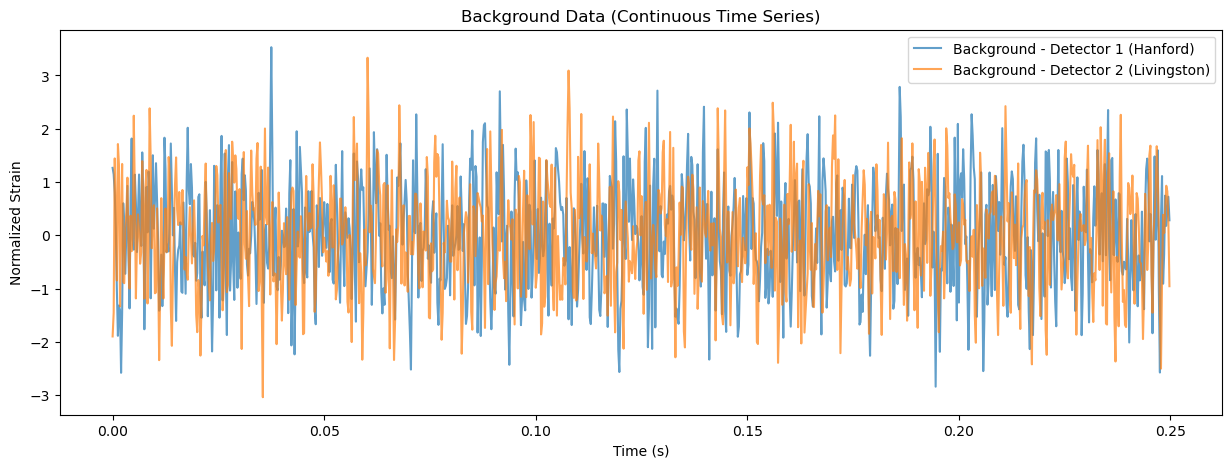

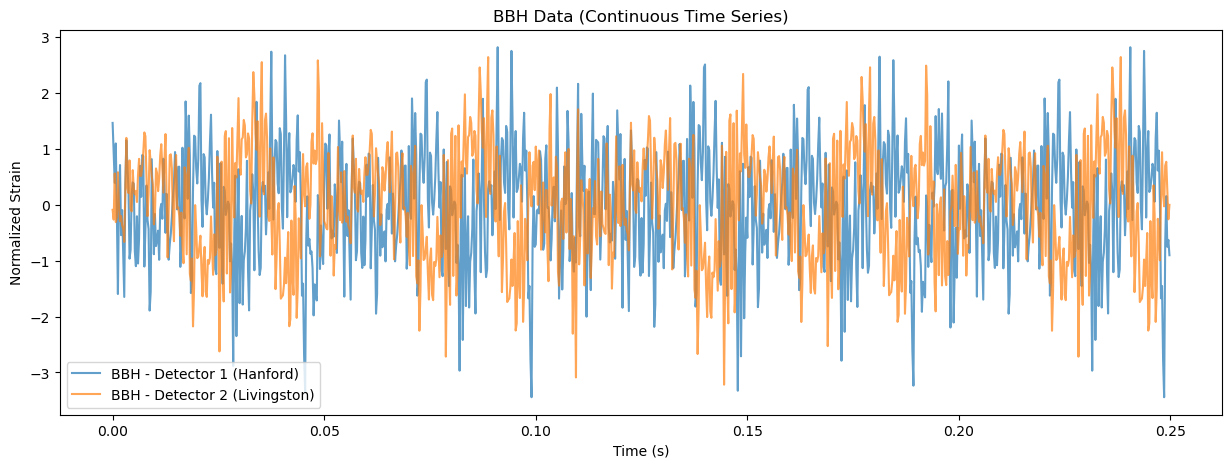

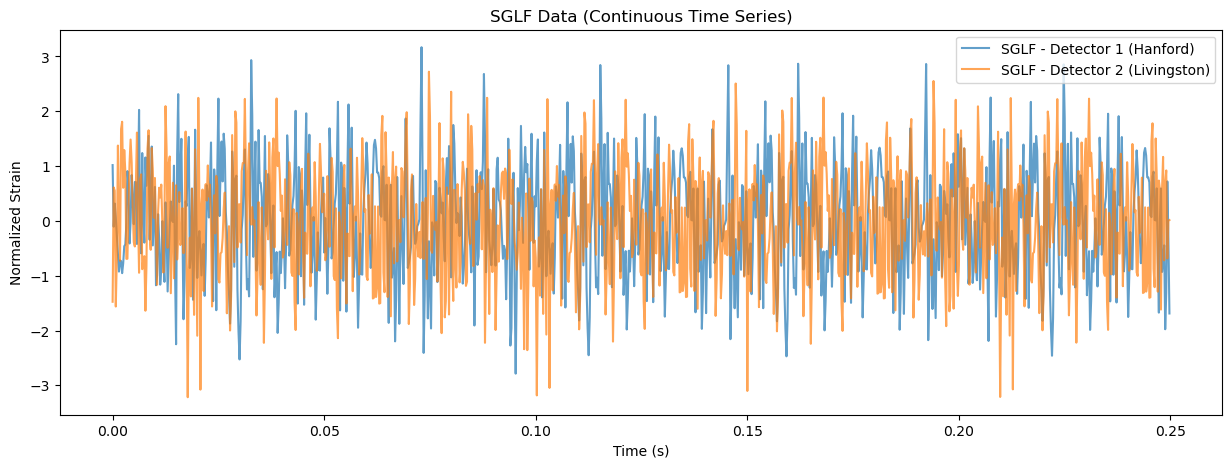

In [26]:
import matplotlib.pyplot as plt

# Concatenate segments to form a continuous time series
background_continuous = background.reshape(-1, 2)[:1000]  # Shape: (100000 * 200, 2)
bbh_continuous = bbh.reshape(-1, 2)[:1000]                # Shape: (100000 * 200, 2)
sglf_continuous = sglf.reshape(-1, 2)[:1000]              # Shape: (100000 * 200, 2)

# Time axis for plotting
time_axis = np.arange(background_continuous.shape[0]) * 0.05 / 200  # 0.05s per 200 points

# Plot the background data
plt.figure(figsize=(15, 5))
plt.plot(time_axis, background_continuous[:, 0], label="Background - Detector 1 (Hanford)", alpha=0.7)
plt.plot(time_axis, background_continuous[:, 1], label="Background - Detector 2 (Livingston)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Strain")
plt.title("Background Data (Continuous Time Series)")
plt.legend()
plt.show()

# Plot the BBH data
plt.figure(figsize=(15, 5))
plt.plot(time_axis, bbh_continuous[:, 0], label="BBH - Detector 1 (Hanford)", alpha=0.7)
plt.plot(time_axis, bbh_continuous[:, 1], label="BBH - Detector 2 (Livingston)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Strain")
plt.title("BBH Data (Continuous Time Series)")
plt.legend()
plt.show()

# Plot the SGLF data
plt.figure(figsize=(15, 5))
plt.plot(time_axis, sglf_continuous[:, 0], label="SGLF - Detector 1 (Hanford)", alpha=0.7)
plt.plot(time_axis, sglf_continuous[:, 1], label="SGLF - Detector 2 (Livingston)", alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Normalized Strain")
plt.title("SGLF Data (Continuous Time Series)")
plt.legend()
plt.show()

In [32]:
x_train, x_test, y_train, y_test = train_test_split(
     background, background, test_size=0.2, random_state=42)

print(f'x train/test shapes: {x_train.shape} {x_test.shape}')
print(f'y train/test shapes: {y_train.shape} {y_test.shape}')

x train/test shapes: (80000, 200, 2) (20000, 200, 2)
y train/test shapes: (80000, 200, 2) (20000, 200, 2)


In [33]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X, batch_size=32):
        return np.mean((self.ae.predict(X, batch_size=batch_size) - X) ** 2, axis=(1,2))

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        self.ae = keras.models.load_model(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 1.8338 - val_loss: 0.7711
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7462 - val_loss: 0.5952
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6052 - val_loss: 0.5329
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.5284 - val_loss: 0.4028
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4029 - val_loss: 0.3165
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3325 - val_loss: 0.2798
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2943 - val_loss: 0.2539
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2662 - val_loss: 0.2276
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.2422 - val_loss: 0.1981
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1876 - val_loss: 0.1266
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1436 - val_loss: 0.0933
Epoch 12/50
2000/2000 ━━━━━━━

In [34]:
# Save the entire model as a SavedModel.
__file__=''
!mkdir -p saved_model
autoencoder.save('')

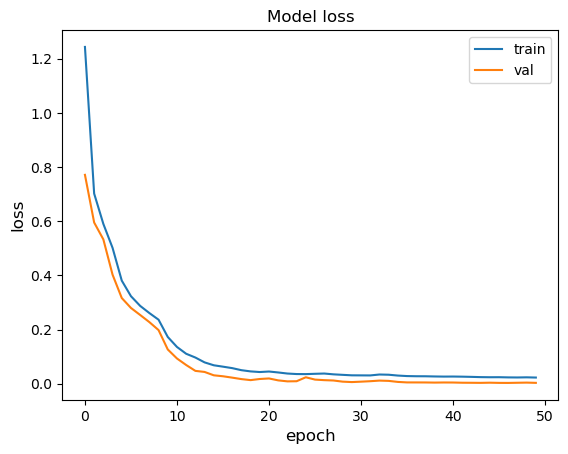

In [35]:
# This is just an example; you would probably like to train the model for more epochs
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 943us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step


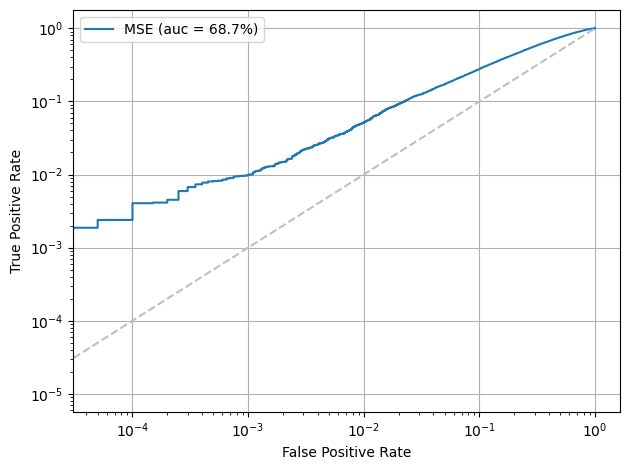

In [36]:
def make_plot_roc_curves(qcd, bsm):

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)


    qcd[::-1].sort()

    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = %.1f%%)'%(auc_loss*100.),
        linewidth=1.5)
    plt.plot(np.linspace(0, 1),np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# evaluate on test background and signal samples
background_test = autoencoder.predict(x_test)
signal_test = autoencoder.predict(bbh)

make_plot_roc_curves(background_test, signal_test)

In [11]:
signal_test.shape

(100000,)

In [50]:
class Model:
    def __init__(self):
        super().__init__()

    def transformer_encoder(self, inputs, head_size, num_heads, ff_dim, dropout=0):
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def dense_decoder(self, inputs, ff_dim, output_dim, dropout=0):
        # Flatten the input to apply dense layers
        x = layers.Flatten()(inputs)
        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = layers.Dense(ff_dim)(x)  # Align dimensions for residual

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        x = x + res

        x = layers.Dense(ff_dim, activation="relu")(x)
        x = layers.Dropout(dropout)(x)
        x = layers.Dense(np.prod(inputs.shape[1:]))(x)  # Output dimension should match the flattened input dimension
        x = layers.LayerNormalization(epsilon=1e-6)(x)

        # Reshape back to original input shape
        x = layers.Reshape(inputs.shape[1:])(x)
        return x + inputs  # Adding input directly, assuming output_dim matches inputs shape[-1]

    def build_model(self, input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, num_dense_blocks, dropout=0, mlp_dropout=0):
        inputs = keras.Input(shape=input_shape)

        # Encoder
        x = inputs
        for _ in range(num_transformer_blocks):
            x = self.transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

        encoder_output = x

        # Decoder
        x = encoder_output
        for _ in range(num_dense_blocks):
            x = self.dense_decoder(x, ff_dim, input_shape[-1], dropout)

        # Output layer
        outputs = layers.Dense(input_shape[-1])(x)

        self.ae = keras.Model(inputs, outputs)
        self.ae.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=1e-4))

    def predict(self, X):
        
        # Use self.clf (loaded model) for predictions
        reconstructed_X = self.clf.predict(X)
        # Compute Mean Squared Error (MSE) as anomaly scores
        mse = np.mean((reconstructed_X - X) ** 2, axis=(1, 2))
        return mse

    def __call__(self, inputs, batch_size=64):
        return self.ae.predict(inputs, batch_size=batch_size)

    def save(self, path):
        self.ae.save(os.path.join(os.path.dirname(__file__), 'model.keras'))

    def load(self):
        """
        Load the pre-trained model architecture and weights.
        """
        # Load the model architecture from a JSON file
        with open(os.path.join(os.path.dirname(__file__), 'model.json'), 'r') as json_file:
            model_json = json_file.read()
            self.clf = tf.keras.models.model_from_json(model_json)

        # Load the model weights
        self.clf.load_weights(os.path.join(os.path.dirname(__file__), 'model.weights.h5'))

    def fit(self, x_train, **kwargs):
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

# Example usage:
input_shape = x_train.shape[1:]
head_size = 64
num_heads = 2
ff_dim = 64
num_transformer_blocks = 2
num_dense_blocks = 1
dropout = 0.1

# build the model
autoencoder = Model()
autoencoder.build_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    num_dense_blocks=num_dense_blocks,
    dropout=dropout
)

# Assuming x_train is your input data
history = autoencoder.fit(
    x_train, # For autoencoders, input is same as output
    validation_split=0.2,
    epochs=25,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 2.5949 - val_loss: 0.9541
Epoch 2/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.9684 - val_loss: 0.7808
Epoch 3/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.7952 - val_loss: 0.6638
Epoch 4/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.6815 - val_loss: 0.6263
Epoch 5/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.6204 - val_loss: 0.5291
Epoch 6/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.5409 - val_loss: 0.4914
Epoch 7/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4817 - val_loss: 0.4391
Epoch 8/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4464 - val_loss: 0.4291
Epoch 9/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 0.4249 - val_loss: 0.4075
Epoch 10/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.4034 - val_loss: 0.3759
Epoch 11/25
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.3845 - val_loss: 0.3568
Epoch 12/25
2000/2000 ━━━━━━━

In [51]:
model_json = autoencoder.ae.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [52]:
autoencoder.ae.save_weights("model.weights.h5")

In [53]:
model = Model()
model.load()

In [54]:
background_test = model.predict(x_test)
signal_test = model.predict(bbh)

625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 934us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step


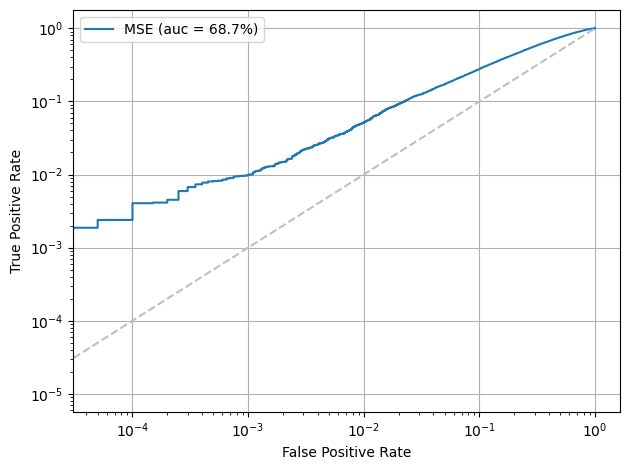

In [40]:
make_plot_roc_curves(background_test, signal_test)

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, Model

class CNN_AE:
    def __init__(self):
        self.ae = None

    def cnn_encoder(self, inputs):
        """Builds the CNN-based encoder."""
        x = layers.Conv1D(filters=64, kernel_size=7, activation="relu", padding="same")(inputs)
        x = layers.MaxPooling1D(pool_size=2, padding="same")(x)
        x = layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same")(x)
        x = layers.MaxPooling1D(pool_size=2, padding="same")(x)
        x = layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(x)
        latent = layers.MaxPooling1D(pool_size=2, padding="same")(x)
        return latent

    def cnn_decoder(self, latent):
        """Builds the CNN-based decoder."""
        x = layers.Conv1D(filters=256, kernel_size=7, activation="relu", padding="same")(latent)
        x = layers.UpSampling1D(size=2)(x)
        x = layers.Conv1D(filters=128, kernel_size=7, activation="relu", padding="same")(x)
        x = layers.UpSampling1D(size=2)(x)
        x = layers.Conv1D(filters=64, kernel_size=7, activation="relu", padding="same")(x)
        x = layers.UpSampling1D(size=2)(x)
        decoded = layers.Conv1D(filters=2, kernel_size=3, activation="sigmoid", padding="same")(x)
        return decoded

    def build_model(self, input_shape):
        inputs = tf.keras.Input(shape=input_shape)
        
        # Encoder
        latent = self.cnn_encoder(inputs)
        
        # Decoder
        decoded = self.cnn_decoder(latent)
        
        # Compile model
        self.ae = tf.keras.Model(inputs, decoded)
        self.ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss="mse")

    def fit(self, x_train, **kwargs):
        """Fits the model on training data."""
        history = self.ae.fit(x_train, x_train, **kwargs)
        return history

    def predict_anomalies(self, X):
        """Predicts anomalies by computing reconstruction errors."""
        reconstructed = self.ae.predict(X)
        return tf.reduce_mean(tf.math.square(X - reconstructed), axis=(1, 2))

    def save_model(self, path):
        self.ae.save(path)

    def load_model(self, path):
        self.ae = tf.keras.models.load_model(path)

# Usage example
input_shape = (200, 2)  # Shape for a single segment
autoencoder = CNN_AE()
autoencoder.build_model(input_shape)

# Train the model (use actual x_train data here)
history = autoencoder.fit(
    x_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 1.0063 - val_loss: 1.0005
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 9/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 10/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005
Epoch 11/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.0005 - val_loss: 1.0005


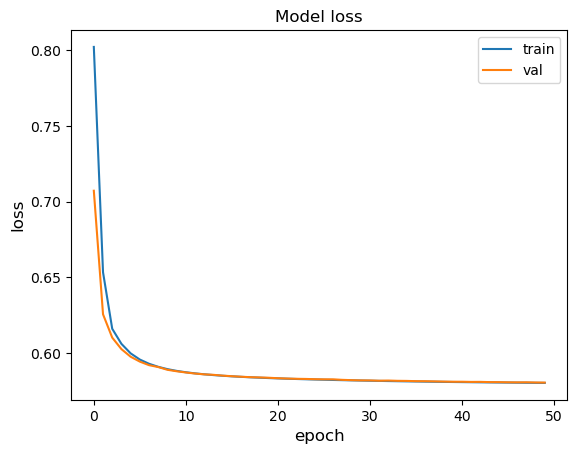

In [70]:
metric = "loss"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("Model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 764us/step
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 3s 810us/step


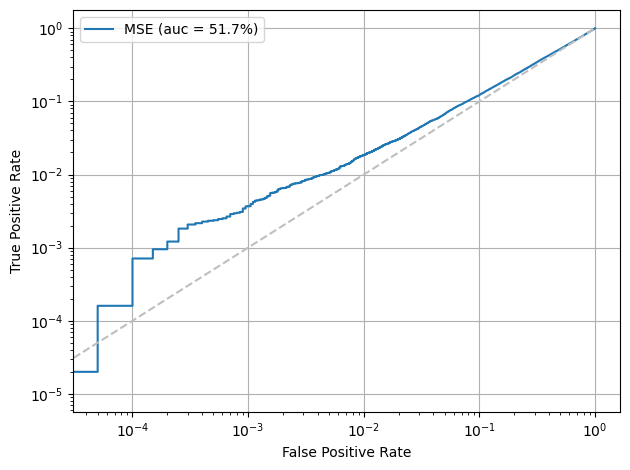

In [73]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

def make_plot_roc_curves(qcd, bsm):
    # Ensure input tensors are converted to NumPy arrays
    qcd = np.array(qcd)
    bsm = np.array(bsm)

    true_val = np.concatenate((np.ones(bsm.shape[0]), np.zeros(qcd.shape[0])))
    pred_val = np.concatenate((bsm, qcd))

    fpr_loss, tpr_loss, threshold_loss = roc_curve(true_val, pred_val)

    auc_loss = auc(fpr_loss, tpr_loss)

    # Sort the QCD data in descending order for proper plotting
    qcd[::-1].sort()

    # Plot ROC curve
    plt.plot(fpr_loss, tpr_loss, '-', label=f'MSE (auc = {auc_loss * 100:.1f}%)', linewidth=1.5)
    plt.plot(np.linspace(0, 1), np.linspace(0, 1), '--', color='0.75')

    plt.semilogx()
    plt.semilogy()
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Evaluate on test background and signal samples
background_test = autoencoder.predict_anomalies(x_test)
signal_test = autoencoder.predict_anomalies(bbh)

# Call the plotting function
make_plot_roc_curves(background_test, signal_test)


In [74]:
background_test

<tf.Tensor: shape=(20000,), dtype=float64, numpy=
array([0.56594469, 0.58666415, 0.60770309, ..., 0.58427123, 0.57802462,
       0.57869762])>